# Consumer's Side

Below is the code for a "Consumer." Our Consumer needs to classify images that are not known to the Provider (7,8,9,0 in our example), and the Consumer has very few of these unknown images (42 samples only). 

In [1]:
from mnist import MnistDataFiltered, plot_mnist
import matplotlib.pyplot as plt

seven_to_zero = [7,8,9,0]
mnist_data = MnistDataFiltered(0,100,seven_to_zero)
print ('number of train samples:',len(mnist_data.x_train))

number of train samples: 42


## All Training Data

Below are all samples available for training the Consumer's model:

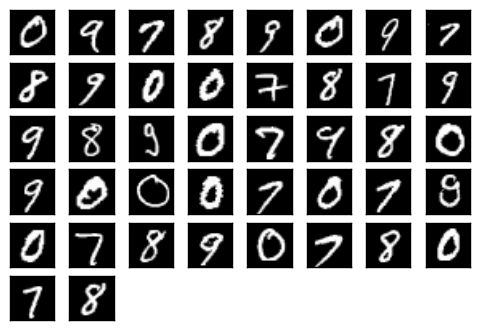

In [2]:
plot_mnist(mnist_data.x_train,len(mnist_data.x_train),8)

## Self-Training

Even if we assume that the Consumer has the expertise to build a model as good as the Provider has, how high can the Consumer get its accuracy score with such a limited number of training samples?

In [3]:
from digit_classifier import DigitClassifier
dc = DigitClassifier(seven_to_zero)
dc.build_graph()
acc_own = []
for i in range(100):
    dc.train(mnist_data.x_train, mnist_data.y_train, 1)
    score=dc.evaluate()[1]
    acc_own += [score]

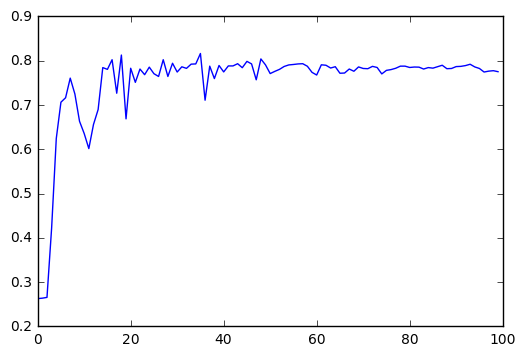

In [4]:
plt.figure()
plt.plot(acc_own)
plt.show()

## Using Transfer Learning

The Consumer below uses the Dopamine protocol to instantiate a trainable object based on the Provider's pre-trained model:

In [5]:
import dopapy
import dopapy.trading as dp
import dopapy.types as dd
from dopapy.core.services.instance.iservice import ILabeledLearningServiceInstance
import numpy as np
import os
import warnings
from mnist import MnistDataFiltered

warnings.filterwarnings('ignore') #Thats just to ignore warnings that are irrelevant for this type of sample

class Consumer(object):
    def __init__(self, port, from_sample, to_sample, name, student_port):
        mnist_data = MnistDataFiltered(from_sample,to_sample,seven_to_zero)
        self.x_train = mnist_data.x_train
        self.y_train = mnist_data.y_train
        self.x_test = mnist_data.x_test
        self.y_test = mnist_data.y_test        
        self.name = name
        self.port = port
        self.student_port = student_port
        self._initialize_session()

    def _initialize_session(self):
        session = dp.create_session(master_password='password123456',
                                    keystore_dir='/data/dopamine/keystore_dir_a/',
                                    web_server_host="127.0.0.1",
                                    web_server_port=self.port,
                                    dopmn_budget=100000,
                                    ether_budget=int(10E18))
        counter_quote = dp.get_counter_quote(url="https://127.0.0.1:"+str(self.student_port), quote_id=0)
        my_service_descriptor = dd.ServiceDescriptor(
            service_role=dd.ServiceRole.CONSUMER,
            input_descriptors=[dd.TensorDescriptor([-1,28,28,1])],
            output_descriptors=[dd.TensorDescriptor([-1])],
            service_type=dd.ServiceType.Learning.LABELED,
            remote_sources=[counter_quote]
        )
        reward_desc = dp.create_reward_descriptor(max_dopamine_price=100)
        reward_desc.add_payment(dd.RewardPaymentType.UPDATE, max_price=10)
        reward_desc.add_payment(dd.RewardPaymentType.FORWARD, max_price=0)
        quote = dp.create_quote_services(
            session=session,
            service_descriptor=my_service_descriptor,
            side=dp.BUY,
            reward_descriptor=reward_desc)
        service = quote.create_service()   
        self.service = service
        self.session = session
      
        
    def train(self):
        self.service.train(input_objects= [dd.Tensor(self.x_train)], labels= [dd.Tensor(self.y_train)])


Here, the Consumer trains the model on its own new data:

In [6]:
from sklearn.metrics import accuracy_score
consumer = Consumer(8022, 0,     100, "A", 8015)

In [7]:
acc_transfer = []
for i in range(100):    
    print('Epoch : ',i)
    consumer.train()
    pred=consumer.service.call(dd.Tensor(consumer.x_test))
    acc_transfer += [accuracy_score(np.argmax(consumer.y_test,axis=1), np.argmax(pred.data,axis=1))]

Epoch :  0
Epoch :  1
Epoch :  2
Epoch :  3
Epoch :  4
Epoch :  5
Epoch :  6
Epoch :  7
Epoch :  8
Epoch :  9
Epoch :  10
Epoch :  11
Epoch :  12
[ERROR:session 0 task runner_executor_thread_2:dopamine.py:215:sync_with_blockchain:2018-01-31 08:02:39,830] -- attempt to refresh transaction data failed - transaction(0x4366bfc5aa618eb306141417658f7f7b86d425d1d8f25b7393be907e1ac76056) is missing in the blockchain, retries(5) 


[ERROR:session 0 task runner_executor_thread_2:dopamine.py:215:sync_with_blockchain:2018-01-31 08:02:39,830] -- attempt to refresh transaction data failed - transaction(0x4366bfc5aa618eb306141417658f7f7b86d425d1d8f25b7393be907e1ac76056) is missing in the blockchain, retries(5) 


Epoch :  13
Epoch :  14
Epoch :  15
Epoch :  16
Epoch :  17
Epoch :  18
Epoch :  19
Epoch :  20
Epoch :  21
Epoch :  22
Epoch :  23
Epoch :  24
Epoch :  25
Epoch :  26
Epoch :  27
Epoch :  28
Epoch :  29
Epoch :  30
Epoch :  31
Epoch :  32
Epoch :  33
Epoch :  34
Epoch :  35
Epoch :  36
Epoch :  37
Epoch :  38
Epoch :  39
Epoch :  40
Epoch :  41
Epoch :  42
Epoch :  43
Epoch :  44
Epoch :  45
Epoch :  46
Epoch :  47
Epoch :  48
Epoch :  49
Epoch :  50
Epoch :  51
Epoch :  52
Epoch :  53
Epoch :  54
Epoch :  55
Epoch :  56
Epoch :  57
Epoch :  58
Epoch :  59
Epoch :  60
Epoch :  61
Epoch :  62
Epoch :  63
Epoch :  64
Epoch :  65
Epoch :  66
[ERROR:session 0 task runner_executor_thread_2:dopamine.py:215:sync_with_blockchain:2018-01-31 09:20:28,684] -- attempt to refresh transaction data failed - transaction(0x21d9ac14d5c6fc8cf5aa5fbb574c2703e43fc433257b428cda90a73002b2a2b0) is missing in the blockchain, retries(5) 


[ERROR:session 0 task runner_executor_thread_2:dopamine.py:215:sync_with_blockchain:2018-01-31 09:20:28,684] -- attempt to refresh transaction data failed - transaction(0x21d9ac14d5c6fc8cf5aa5fbb574c2703e43fc433257b428cda90a73002b2a2b0) is missing in the blockchain, retries(5) 


Epoch :  67
Epoch :  68
Epoch :  69
Epoch :  70
Epoch :  71
Epoch :  72
Epoch :  73
Epoch :  74
Epoch :  75
Epoch :  76
Epoch :  77
Epoch :  78
Epoch :  79
Epoch :  80
Epoch :  81
Epoch :  82
Epoch :  83
Epoch :  84
Epoch :  85
Epoch :  86
Epoch :  87
Epoch :  88
Epoch :  89
Epoch :  90
Epoch :  91
Epoch :  92
Epoch :  93
Epoch :  94
Epoch :  95
Epoch :  96
Epoch :  97
Epoch :  98
Epoch :  99


When comparing the two possibilities (self-learning vs transfer learning), it's clear that (at least in this case) transfer learning is highly beneficial:

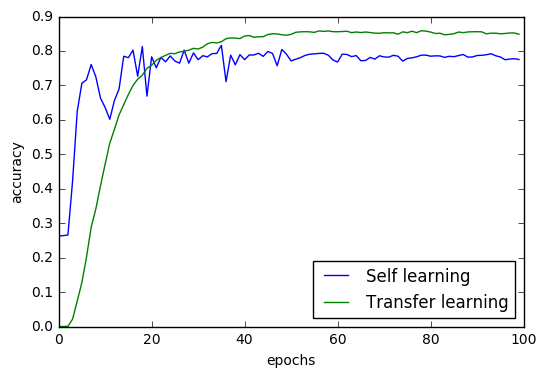

In [8]:
plt.figure()
plt.plot(acc_own, label='Self learning')
plt.plot(acc_transfer, label='Transfer learning')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.axes().set_xlim(0, 100)
plt.show()